In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

## Read in netCDF data

In [2]:
from scipy.io import netcdf_file

# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
f = netcdf_file("data2.nc")
f.variables

{'ugos': <scipy.io._netcdf.netcdf_variable at 0x7f168ec71750>,
 'vgos': <scipy.io._netcdf.netcdf_variable at 0x7f168e7610c0>,
 'vgosa': <scipy.io._netcdf.netcdf_variable at 0x7f168e7610f0>,
 'crs': <scipy.io._netcdf.netcdf_variable at 0x7f168e761180>,
 'err_vgosa': <scipy.io._netcdf.netcdf_variable at 0x7f168e761210>,
 'latitude': <scipy.io._netcdf.netcdf_variable at 0x7f168e7612d0>,
 'nv': <scipy.io._netcdf.netcdf_variable at 0x7f168e761360>,
 'sla': <scipy.io._netcdf.netcdf_variable at 0x7f168e7613f0>,
 'ugosa': <scipy.io._netcdf.netcdf_variable at 0x7f168e761540>,
 'lat_bnds': <scipy.io._netcdf.netcdf_variable at 0x7f168e7615a0>,
 'flag_ice': <scipy.io._netcdf.netcdf_variable at 0x7f168e761630>,
 'adt': <scipy.io._netcdf.netcdf_variable at 0x7f168e7616f0>,
 'err_ugosa': <scipy.io._netcdf.netcdf_variable at 0x7f168e761750>,
 'tpa_correction': <scipy.io._netcdf.netcdf_variable at 0x7f168e7617e0>,
 'time': <scipy.io._netcdf.netcdf_variable at 0x7f168e761870>,
 'longitude': <scipy.io._n

## Extract Lat/Long

In [3]:
lat = f.variables['latitude'].data
long = f.variables['longitude'].data

## Show data points on map

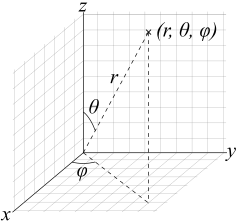
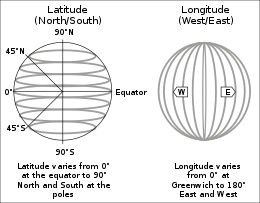
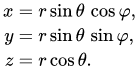

<IPython.core.display.Javascript object>


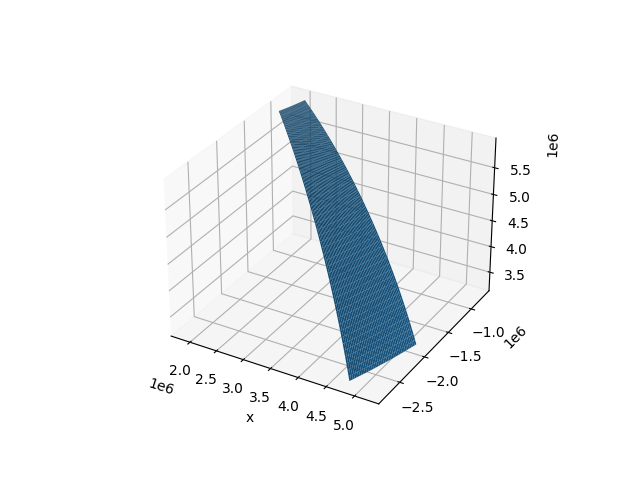

Text(0.5, 0, 'x')

In [6]:
radius = 6371e3 # obviously not the radius of the earth but makes plot less crazy
latv, longv = np.meshgrid(np.deg2rad(lat), np.deg2rad(long), indexing='ij')
x = radius * np.sin(latv) * np.cos(longv)
y = radius * np.sin(latv) * np.sin(longv)
z = radius * np.cos(latv)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(x,y,z)
ax.set_xlabel("x")

## Extract Velocity

x component of velocity

<IPython.core.display.Javascript object>


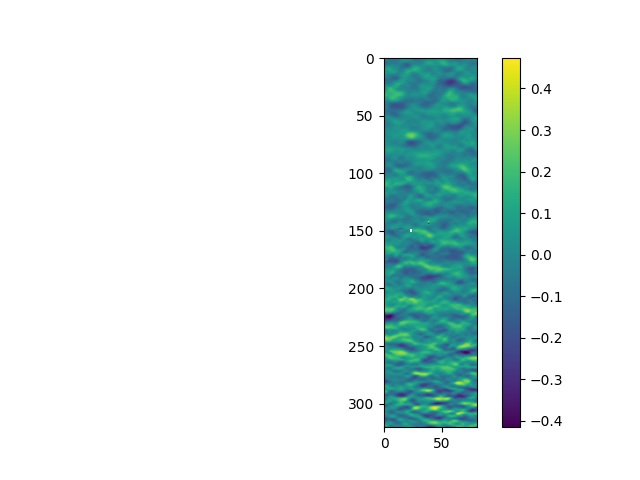

In [7]:
vel_x = f.variables['ugos'].data.squeeze()
vel_x.shape
plt.figure()
plt.imshow(vel_x)
plt.colorbar()

y component of velocity

<IPython.core.display.Javascript object>


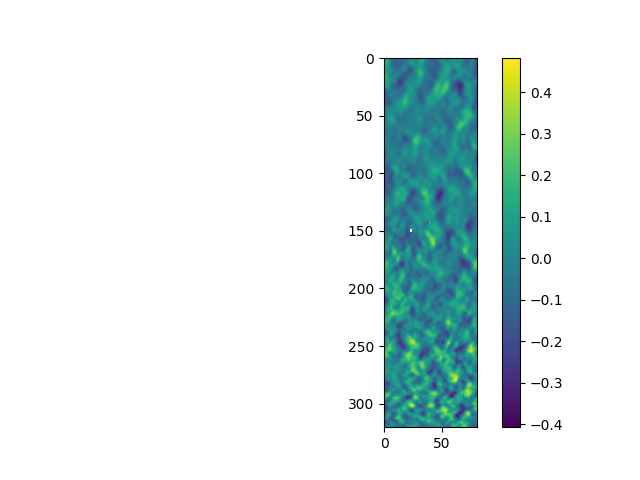

In [8]:
vel_y = f.variables['vgos'].data.squeeze()
vel_y.shape
plt.figure()
plt.imshow(vel_y)
plt.colorbar()

## Are there any missing values?

In [9]:
print(f"Missing values in x: {np.isnan(np.amin(vel_x))}")
print(f"Missing values in y: {np.isnan(np.amin(vel_y))}")

Missing values in x: True
Missing values in y: True


## Impute Missing Values using interpolation

In [13]:
from scipy.interpolate import griddata

def interpolate_missing_point(data, mask, method = 'linear'):
    
    # get height and width
    m, n = data.shape[:2]
    xx, yy = np.meshgrid(np.arange(n), np.arange(m))
    
    # get locations of the good data
    known_x = xx[~mask]
    known_y = yy[~mask]
    known_data = data[~mask]
    # get locations of the missing data
    missing_x = xx[mask]
    missing_y = yy[mask]
    
    # interpolate over the good data
    interp_values = griddata(
        (known_x, known_y), known_data, (missing_x, missing_y),
        method=method
    )
    
    # put in the interpolated value where required
    interp_data = data.copy()
    interp_data[missing_y, missing_x] = interp_values

    return interp_data

imputed_vel_x = interpolate_missing_point(vel_x, np.ma.masked_invalid(vel_x).mask)
imputed_vel_y = interpolate_missing_point(vel_y, np.ma.masked_invalid(vel_y).mask)

## Plot data again to check nothing crazy has happened

<IPython.core.display.Javascript object>


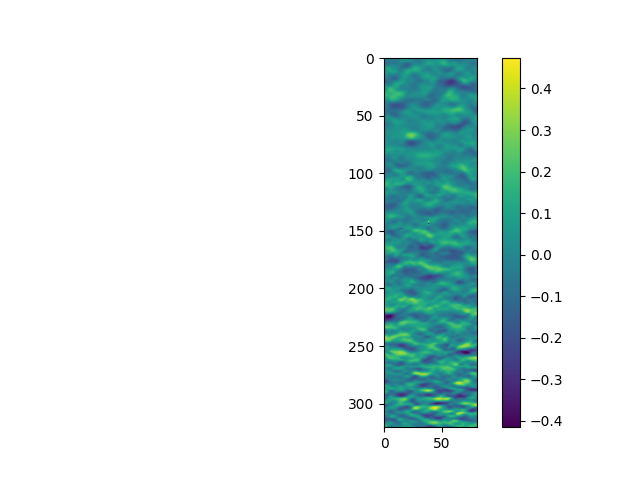

In [14]:
plt.figure()
plt.imshow(imputed_vel_x)
plt.colorbar()

<IPython.core.display.Javascript object>


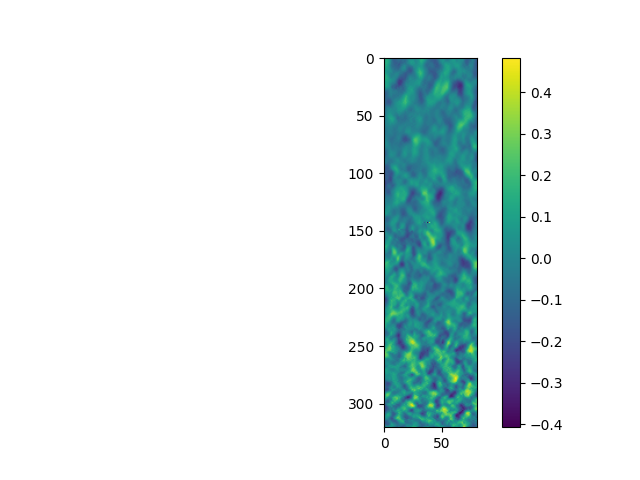

In [15]:
plt.figure()
plt.imshow(imputed_vel_y)
plt.colorbar()

## Quiver Plot

In [ ]:
vel_magnitude = np.hypot(imputed_vel_x, imputed_vel_y)

# start with magnitude of velocity as background
plt.figure()
plt.imshow(vel_magnitude, origin='lower')
plt.quiver(imputed_vel_x, imputed_vel_y, color='r', scale=5)

## Compute curl

Velocity Field $\mathbf{v}(x,y) = (v_x(x,y), v_y(x,y))$

$$
\nabla \times \mathbf{v} = \frac{\partial v_y}{\partial x} - \frac{\partial v_x}{\partial y}
$$

In [ ]:
# would probably be good to compute the correct dx and dy
# or maybe we dont have to do this is we do some clever projection?
curl = np.gradient(imputed_vel_y, axis=1) - np.gradient(imputed_vel_x, axis=0)
plt.figure()
plt.imshow(curl)
plt.colorbar()

## Okubo–Weiss parameter
Okubo, A., 1970: Horizontal dispersion of floatable particles in the vicinity of velocity singularities such as convergences. Deep-Sea Res., 17, 445–454

A nice reference for how to actually calculate the thing: https://miolaseyne.ifremer.fr/sciences/ELISA/isern_AEs_Okubo.pdf

$$
W = s_n^2 + s_s^2 + \omega^2
$$

where $s_n$, $s_s$ and $\omega$ are the normal and the shear
components of strain and the curl of the flow defined respectively by

$$
s_n = \frac{\partial v_x}{\partial x} - \frac{\partial v_y}{\partial y}
$$

$$
s_s = \frac{\partial v_x}{\partial x} + \frac{\partial v_y}{\partial y}
$$

$$
\omega = \frac{\partial v_y}{\partial x} - \frac{\partial v_x}{\partial y}
$$

In [ ]:
strain_normal = np.gradient(imputed_vel_x, axis=1) - np.gradient(imputed_vel_y, axis=0)
strain_shear = np.gradient(imputed_vel_y, axis=1) + np.gradient(imputed_vel_x, axis=0)

W = strain_normal**2 + strain_shear**2 + curl**2

plt.figure()
plt.imshow(W)
plt.clim(0,0.2)
plt.colorbar()

## Thresholding

One naive approach might be to segement the eddies using a fixed threshold value

In [ ]:
curl_eddies = np.ma.masked_where(np.abs(curl) < 0.01, vel_magnitude)
W_eddies = np.ma.masked_where(W < 0.01, vel_magnitude)

plt.figure()
plt.imshow(curl_eddies)
plt.figure()
plt.imshow(W_eddies)

## Spectral Clustering

## Integrating Particles

$$
\mathbf{x} = (x,y)
$$
$$
\dot{\mathbf{x}} = \mathbf{v}(\mathbf{x})
$$

In [ ]:
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp

# first build an interpolator over the x and y velocity
# for now dont use any proper coordinates just [0,m]*[0,n]
m,n = imputed_vel_x.shape
x = np.linspace(0, n, n)
y = np.linspace(0, m, m)
method = "linear"

interp_vel_x = RegularGridInterpolator((x, y), vel_x.T, method=method)
interp_vel_y = RegularGridInterpolator((x, y), vel_y.T, method=method)

def rhs(t, x):
    try:
        return [interp_vel_x(x).squeeze(), interp_vel_y(x).squeeze()]
    except ValueError:
        # particle has left domain
        return [0, 0]

# ics of (55, 300) maybe an eddie?
sol = solve_ivp(rhs, (0, 500), [55, 300], max_step=1)
plt.figure()
plt.imshow(vel_magnitude, origin='lower', interpolation="bilinear")
plt.plot(sol.y[0], sol.y[1], 'r-')

Look at guassian curvature? A circle has curvature $\frac{1}{r^2}$